# Diffusion 扩散模型 之 Langevin dynamics

这是 diffusion 扩散模型系列第二部分，我们将解释如何用训练好的模型生成样本，着重介绍 Langevin dynamics 方法。

本部分包括以下内容：
  1. 梯度上升法
  2. Langevin dynamics
  
笔记参考：https://github.com/acids-ircam/diffusion_models

根据第一部分的介绍，我们知道了怎样通过 score matching 方法训练得到模型，比如使用 Denoising Score Matching 方法，模型训练如下：

In [4]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
from utils.helper_plot import hdr_plot_style

hdr_plot_style()

def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.tensor(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)


def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss


# Our approximation model
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)

# Create ADAM optimizer over our model
optimizer = optim.Adam(model.parameters(), lr=1e-3)

data = sample_batch(10**4).T
dataset = torch.tensor(data.T).float()
for t in range(5000):
    # Compute the loss.
    loss = denoising_score_matching(model, dataset)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    # Print loss
    if ((t % 1000) == 0):
        print(loss)

tensor(9993.2754, grad_fn=<MulBackward0>)
tensor(9961.4668, grad_fn=<MulBackward0>)
tensor(9913.8848, grad_fn=<MulBackward0>)
tensor(9995.2852, grad_fn=<MulBackward0>)
tensor(10020.6484, grad_fn=<MulBackward0>)


##  1 梯度上升法

模型训练好之后,就可以预测概率梯度，即 $\mathcal{F}_{\theta}(\mathbf{x}) \approx \nabla_x \log p(x)$。

我们可以使用梯度上升法，首先生成一个初始样本 $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ ，然后通过梯度信息找到局部最大值，逐步生成最终的样本：

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \epsilon \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t)$$

式中， $\epsilon$ 表示梯度方向上的步长。

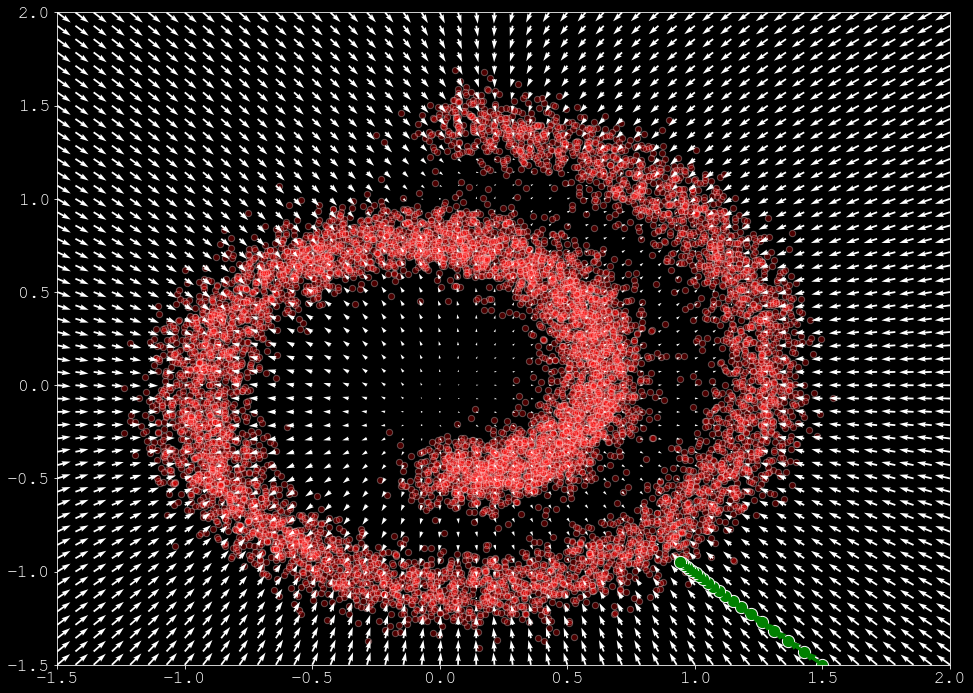

In [7]:
def sample_simple(model, x, n_steps=20, eps=1e-3):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        x = x + eps * model(x)
        x_sequence.append(x.unsqueeze(0))
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_simple(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)

# draw arrows for each  step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)

##  2 Langevin dynamics

然而, 上述过程并没有产生真实的样本 $\mathbf{x} \sim p(\mathbf{x})$。为了获得真实样本，可以使用 Langevin dynamics。

Langevin dynamics 采样方法与 MCMC 方法类似, 递归式地生成样本：

$$\mathbf{x}_{t + 1} = \mathbf{x}_t + \frac{\epsilon}{2} \nabla_{\mathbf{x}_t} log p(\mathbf{x}_t) + \sqrt{\epsilon} \mathbf{z}_{t}$$

式中， $\mathbf{z}_{t}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$。当 $\epsilon \rightarrow 0, t \rightarrow \inf$， $\mathbf{x}_t$ 将会收敛到真实的样本分布 $p(\mathbf{x})$。

为了执行该采样过程, 我们可以再次从初始样本 $\mathbf{x}_{0} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ 出发, 在每一步中逐步降低 $\epsilon \rightarrow 0$ ,最后将得到 $p(\mathbf{x})$。

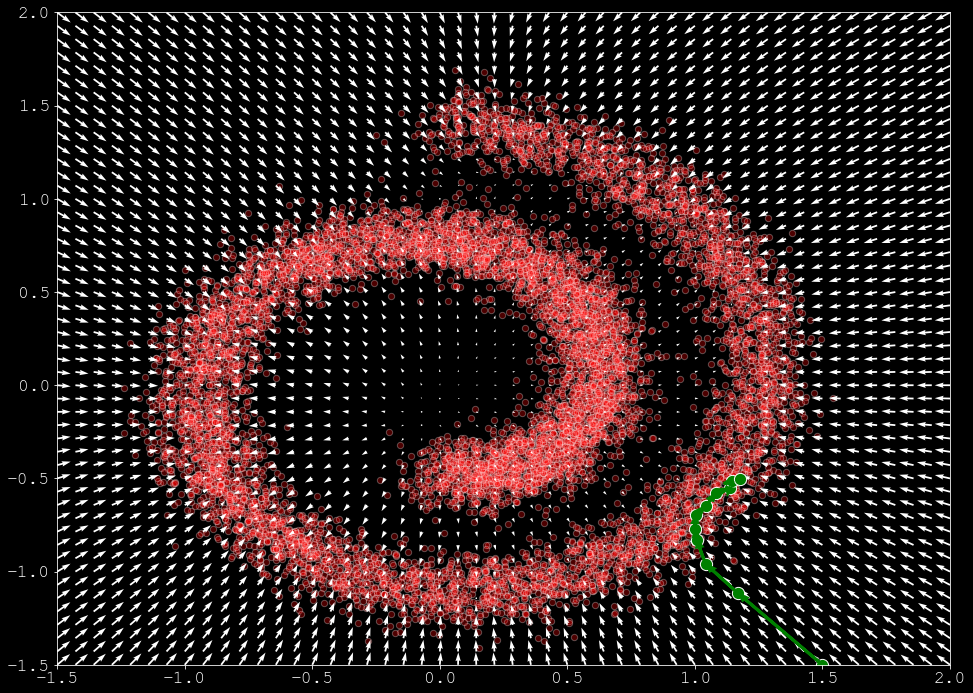

In [6]:
def sample_langevin(model, x, n_steps=10, eps=1e-2, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='green', edgecolor='white', s=150)

# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="green", linewidth=3)